# Homography Estimation By RANSAC 

In [1]:
import random
import math 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import getPerspectiveTransform

## Homography functions

In [2]:
def get_random_4_indices(points_length):
    '''
    take 4 random unique numbers 'indices' between [0 - points_length]
    '''
    return random.sample(range(0, points_length), 4)

def check_if_good_homography(H):
    '''
    source https://answers.opencv.org/question/2588/check-if-homography-is-good/
    '''
    if len(H) == 0:
        return False
    
    det = H[0, 0] * H[1, 1] - H[1, 0] * H[0, 1];
    if (det < 0.0):
        return False
    
    N1 = math.sqrt(H[0, 0] * H[0, 0] + H[1, 0] * H[1, 0]);
    if (N1 > 4 or N1 < 0.1):
        return False
    
    N2 = math.sqrt(H[0, 1] * H[0, 1] + H[1, 1] * H[1, 1]);
    if (N2 > 4 or N2 < 0.1):
        return False
    
    N3 = math.sqrt(H[2, 0] * H[2, 0] + H[2, 1] * H[2, 1]);
    if (N3 > 0.002):
        return False
    
    return True

def get_inliers_by_distance(pts1, pts2, e):
    '''
    take distances between src points and qry points, 
    add the pair if distance less than e
    '''
    distances = np.linalg.norm(pts1-pts2, axis=2).flatten()
    inliers_indices = np.where(distances < e)
    inliers = np.concatenate((pts1[inliers_indices],pts2[inliers_indices]),axis=1)
    return inliers
    
def apply_ransac(points_view1, points_view2, iterations = 1000, e = 4, inliers_thresh=0.7):
    '''
    calculate the homography matrix between match pairs from points_view1 & points_view2
    '''
    max_inliers = []
    out_homography_matrix = None
    for i in range(iterations):
        # choose 4 random indices
        random_4_index = get_random_4_indices(len(points_view1))
        
        # calculate the transformation for these indices from view1 to view2
        rnd_pairs1 = points_view1[random_4_index]
        rnd_pairs2 = points_view2[random_4_index]
        homography_matrix = cv2.getPerspectiveTransform(rnd_pairs1, rnd_pairs2) # or use getPerspectiveTransform from utils.py
        is_correct_homography = check_if_good_homography(homography_matrix)
        if is_correct_homography: 
            # project the view1 to view2 by homography_matrix (you can use getPerspectiveTransform from utils.py)
            projected_view1_pts = cv2.perspectiveTransform(points_view1, homography_matrix) 
            inliers = get_inliers_by_distance(projected_view1_pts, points_view2, e)
            if len(inliers) > len(max_inliers):
                max_inliers = inliers
                out_homography_matrix = homography_matrix
        
        # check if we have enough inliers then we reached to accepted solution
        if  len(max_inliers) > (len(points_view1)*inliers_thresh):
            break
    return out_homography_matrix, max_inliers

## Testing 

## 1.Extracting correspondence matching

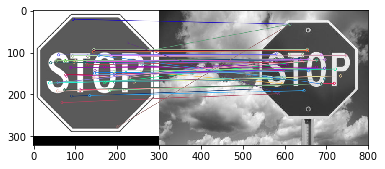

In [3]:
# we will use surf to detect the keypoints of view1 & view2
surf = cv2.xfeatures2d.SURF_create(400)

img1 = cv2.imread('1.jpg',0)
kp1, des1 = surf.detectAndCompute(img1, None)

img2 = cv2.imread('2.jpg',0)
kp2, des2 = surf.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    img_matches = cv2.drawMatches(img1,kp1,img2,kp2,good,None,flags=2)
    plt.imshow(img_matches),plt.show()
else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

## 2.Testing Get Homography Function

In [4]:
h, inlier_pairs = apply_ransac(src_pts, dst_pts)

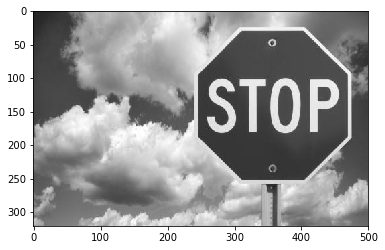

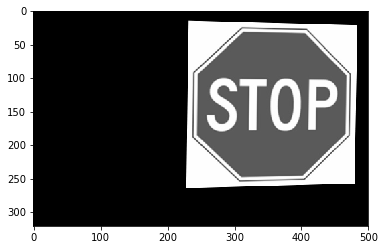

In [5]:
maxWidth = max(int(img1.shape[1]), int(img2.shape[1]))
maxHeight = max(int(img1.shape[0]), int(img2.shape[0]))

warp_img1 = cv2.warpPerspective(img1, h, (maxWidth, maxHeight))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB))
plt.figure()
plt.imshow(cv2.cvtColor(warp_img1, cv2.COLOR_GRAY2RGB))